In [1]:
import re
import random
import pandas as pd
import hashlib

In [2]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

# if cards_to_age['age'].mean() > 80: age_factor = .5
# else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())
cards_to_age['head_count'] = cards_to_age.groupby('head')['head'].transform("count")


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [3]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Power BI,117.121303,3.549130,12.579426,33
Pandas,297.404336,33.044926,86.727848,9
CCH Axcess,627.126268,21.625044,64.114811,29
DAX,649.277270,72.141919,259.298519,9
Azure DevOps Pipelines,682.503511,68.250351,158.489299,10
Azure AD Authentication,714.505465,89.313183,207.286597,8
Azure Private DNS,833.424054,92.602673,250.096615,9
Azure Functions + PP365,881.209553,62.943540,109.090179,14
Terraform,989.378714,82.448226,318.328784,12
TSQL,1304.896282,54.370678,167.703657,24


# Histogram

sum of ages: ~40788.76


<Axes: >

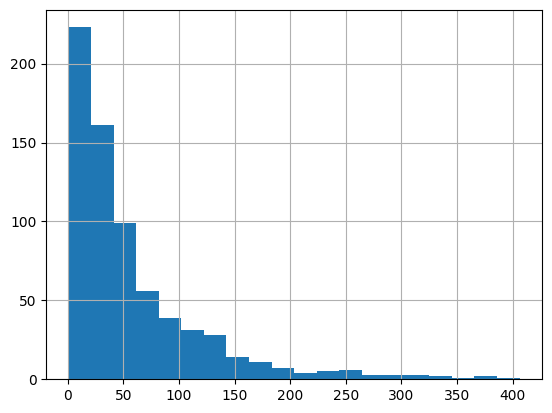

In [4]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~40788.76


<Axes: >

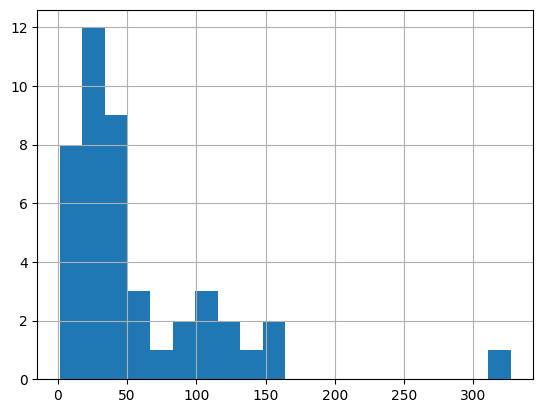

In [5]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Azure Developer Associate']['age'].hist(bins=20)

# Completely Random Shuffle

In [6]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [7]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [8]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

## Headers with greatest age sum first

In [9]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)
# existing_cards.head(10)

## Header with oldest cards first

In [10]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# Focus on one header

In [11]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Headers with greatest mean card age first

In [12]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [13]:
n=3
m=existing_cards.shape[0]//100
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 699
Total card age: 40788.76


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold
19,Vocab,"Something Rotten, Fforde\nCazique\nnoun | kuh-...",38d4ea136ae167b71b3a29817fe5de7d,-377.114483,63.26455,377.114483,-3795.872997,0.39811,60,0,0
20,Vocab,"Jingo, Pratchett\nPro tem\nadverb/adjective | ...",112b5b88bfde51d68292c8520c9d9436,-236.204116,63.26455,377.114483,-3795.872997,0.39811,60,3,0
21,Vocab,"Well of Lost Plots, Fforde\nMilliner\nnoun | M...",fa8900c41cde414530be99dcb388c6cd,-136.122202,63.26455,377.114483,-3795.872997,0.39811,60,6,0
22,Vocab,"Jingo, Pratchett\nEquerry\nnoun | EK-wuh-ree\n...",e70e016f2f6d24855ab61927dd4dbef6,-118.325766,63.26455,377.114483,-3795.872997,0.39811,60,9,0
23,Vocab,"Something Rotten, Fforde\nMuslin (curtains)\nn...",eb83088ac84321e16f95b700f58e4cf6,-94.399927,63.26455,377.114483,-3795.872997,0.39811,60,12,0
499,Vocab,"Well of Lost Plots, Fforde\nInsouciance\nnoun ...",ae15401d43ed91aa235054578c87ffd1,-67.484314,63.26455,377.114483,-3795.872997,0.39811,60,15,0
264,Vocab,"Well of Lost Plots, Fforde\nReigate\nnoun | RY...",ea7311db7ab366d8a04c166f79592837,-63.894620,63.26455,377.114483,-3795.872997,0.39811,60,18,0
26,Vocab,Lost in a Good Book\nPerfidious: Deceitful and...,750c6845f7ac25a042afc610c9644a16,-59.621508,63.26455,377.114483,-3795.872997,0.39811,60,21,0
27,Vocab,"Something Rotten, Fforde\nTimpet\nnoun | TIM-p...",cdaef1f8166f9351b220c1f851ffde58,-52.377444,63.26455,377.114483,-3795.872997,0.39811,60,24,0
28,Vocab,"Well of Lost Plots, Fforde\nPinafore\nnoun | P...",ca575c0f756990a24e858ffc514308ef,-40.639614,63.26455,377.114483,-3795.872997,0.39811,60,27,0


## Age Mean

In [14]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [15]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [16]:
# n=10
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
#     existing_cards['subject_highest_age'] *= -1
# existing_cards.sort_values(['n_fold', 'frequency', 'subject_highest_age', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [17]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [18]:
if existing_cards.age.sum() < 0:
    asc = True
else: asc = False
existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold
39,Asynchronous Python,asyncio.Future\nA low-level object representin...,b901a57e93a160736ed15c21d112b8b1,-406.268006,89.608782,406.268006,-3405.133717,0.405830,38,0,0
19,Vocab,"Something Rotten, Fforde\nCazique\nnoun | kuh-...",38d4ea136ae167b71b3a29817fe5de7d,-377.114483,63.264550,377.114483,-3795.872997,0.398110,60,0,0
87,FSLogix,Q: How does FSLogix improve Office 365 perform...,f35dc0360cf624fcdfa25708f25b7398,-366.528666,80.096276,366.528666,-2482.984563,0.967591,31,0,0
135,Azure Compute Gallery,SAS Token (Shared Access Signature) – A tempor...,16543cefaf9d760fb4860bf0a6fcb4bb,-355.690679,65.079824,355.690679,-2147.634202,0.290575,33,0,0
279,Asynchronous Python,Coroutine Object\nThe result of calling an asy...,877cc6e7d0264598007bf336b88f4c3e,-329.110472,89.608782,406.268006,-3405.133717,0.405830,38,1,1
98,Azure Developer Associate,The .NET SDK for Azure Cosmos DB for NoSQL shi...,f5da4a10007b58ba8af2aaafb7b97a48,-326.936358,59.007721,326.936358,-2596.339714,0.919864,44,0,0
189,Terraform,You can create and use Terraform modules that ...,dee44c7482afdda345bd10bdad89f932,-318.328784,82.448226,318.328784,-989.378714,0.349070,12,0,0
113,PowerShell Modules,PSReadLine Module\n\nDefinition: A module that...,b41f499c95e1fc0bd9767a6315e4b432,-317.361481,87.590209,317.361481,-2364.935637,0.107992,27,0,0
326,FSLogix,Redirector Driver:\nA mechanism within FSLogix...,f51a72bfb75cf817d822f0fb50b94a12,-314.605563,80.096276,366.528666,-2482.984563,0.967591,31,1,1
162,C# Basics,What are common libraries and frameworks in C#...,d714cbc1740b344f84ed84278b332f36,-290.187355,67.676253,290.187355,-1624.230064,0.163525,24,0,0


In [19]:
existing_cards['age'].mean()

-58.35302291772134